In [3]:
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import traja

In [4]:
df_sample = pd.read_csv('./train_filtered_sample.csv')
df_sample.head(3)

,uid,lat,lng,datetime,trip_id,call_type
0,20000003,41.143401,-8.602875,2013-09-22 01:25:17,1379823917620000003,A
1,20000003,41.142033,-8.601894,2013-09-22 01:25:32,1379823917620000003,A
2,20000003,41.139567,-8.601381,2013-09-22 01:25:47,1379823917620000003,A


In [5]:
df = pd.DataFrame()
df['x'] = df_sample['lng']
df['y'] = df_sample['lat']
df['ID'] = df_sample['trip_id']

In [6]:
for col in ['x', 'y']:
    scaler = preprocessing.RobustScaler()
    scaled = scaler.fit_transform(df[[col]])
    df[col] = scaled

In [7]:
from traja.dataset import MultiModalDataLoader
batch_size = 10 # How many sequences to train every step. Constrained by GPU memory.
num_past = 3 # How many time steps from which to learn the time series
num_future = num_past # How many time steps to predict
split_by_id = False # Whether to split data into training, test and validation sets based on
                    # the animal's ID or not. If True, an animal's entire trajectory will only
                    # be used for training, or only for testing and so on.
                    # If your animals are territorial (like Jaguars) and you want to forecast
                    # their trajectories, you want this to be false. If, however, you want to
                    # classify the group membership of an animal, you want this to be true,
                    # so that you can verify that previously unseen animals get assigned to
                    # the correct class.
dataloaders = MultiModalDataLoader(df, batch_size=batch_size, n_past=num_past, n_future=num_future, num_workers=1, split_by_id=split_by_id)

In [8]:
from traja.models.predictive_models.lstm import LSTM
input_size = 2 # Number of input dimensions (normally x, y)
output_size = 2 # Same as input_size when predicting
num_layers = 5 # Number of LSTM layers. Deeper learns more complex patterns but overfits.
hidden_size = 8 # Width of layers. Wider learns bigger patterns but overfits. Try 32, 64, 128, 256, 512
dropout = 0.1 # Ignore some network connections. Improves generalisation.

model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             output_size=output_size,
             dropout=dropout,
             batch_size=batch_size)

In [9]:
from traja.models.train import HybridTrainer

optimizer_type = 'Adam' # Nonlinear optimiser with momentum
loss_type = 'huber'
epochs = 18

# Trainer
trainer = HybridTrainer(model=model,
                        optimizer_type=optimizer_type,
                        loss_type=loss_type)
# Train the model
trainer.fit(dataloaders=dataloaders, model_save_path='./model.pt', epochs=epochs, training_mode='forecasting')

Epoch 1 | forecasting loss 0.11303099244832993
Epoch 2 | forecasting loss 0.018966346979141235
Epoch 3 | forecasting loss 0.013241377659142017
Epoch 4 | forecasting loss 0.01268817950040102
Epoch 5 | forecasting loss 0.012577618472278118
Epoch 6 | forecasting loss 0.01257654931396246
Epoch 7 | forecasting loss 0.012543834745883942
Epoch 8 | forecasting loss 0.012494871392846107
Epoch 9 | forecasting loss 0.01237295288592577
====> Mean Test set forecasting loss: 0.0176
Epoch 10 | forecasting loss 0.012392144650220871
Epoch 11 | forecasting loss 0.012483195401728153
Epoch 12 | forecasting loss 0.012438688427209854
Epoch 13 | forecasting loss 0.012435880489647388
Epoch 14 | forecasting loss 0.012405965477228165
Epoch 15 | forecasting loss 0.012417521327733994
Epoch 16 | forecasting loss 0.01234265323728323
Epoch 17 | forecasting loss 0.01231191772967577
Epoch 18 | forecasting loss 0.012208097614347935
Model and hyperparameters saved at /home/eu/minicurso


In [10]:
validation_loader = dataloaders['sequential_validation_loader']

trainer.validate(validation_loader)

====> Mean Validation set generator loss: 0.1033


(0.1032792459997093, 0.0, 0.0)

In [22]:
import torch
from matplotlib import pyplot as plt
from functools import reduce 
def pred_batch(model, dataloader, index):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    batch_size = model.batch_size
    input_size = model.input_size

    data, target, category, parameters, classes = list(iter(dataloader))[index]
    data = data.float().to(device)
    prediction = model(data, latent=False)

    # Send tensors to CPU so numpy can work with them
    pred = prediction[batch_size - 1 : batch_size, :].cpu().squeeze().detach().numpy()
    target = target.clone().detach()[batch_size - 1 : batch_size, :].squeeze()
    real = target.cpu()
    data_size = reduce(lambda x, y: x * y, list(data.cpu().shape))
    data = data.cpu().reshape((int(data_size/input_size), input_size)).detach().numpy()
    pred += data[-1] - pred[0]
    return data, real, pred

def plot_prediction(data, real, pred):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(data[:, 0], data[:, 1], label="History")
    ax[0].plot(pred[:, 0], pred[:, 1], label="Pred")
    ax[0].plot(real[:, 0], real[:, 1], label="Real")

    ax[1].scatter(pred[:, 0], pred[:, 1], label="Pred")
    ax[1].scatter(real[:, 0], real[:, 1], label="Real")

    for a in ax:
        a.legend()
    plt.show()

In [12]:
minor_mse = float('inf')
minor_i = -1
for i in tqdm(range(len(list(iter(validation_loader))))):
    batch_index = i # The batch you want to plot
    data, real, pred = pred_batch(model, validation_loader, batch_index)
    mse = mean_squared_error(real, pred)
    if mse < minor_mse:
        minor_mse = mse
        minor_i = i

100%|██████████| 126/126 [02:25<00:00,  1.15s/it]


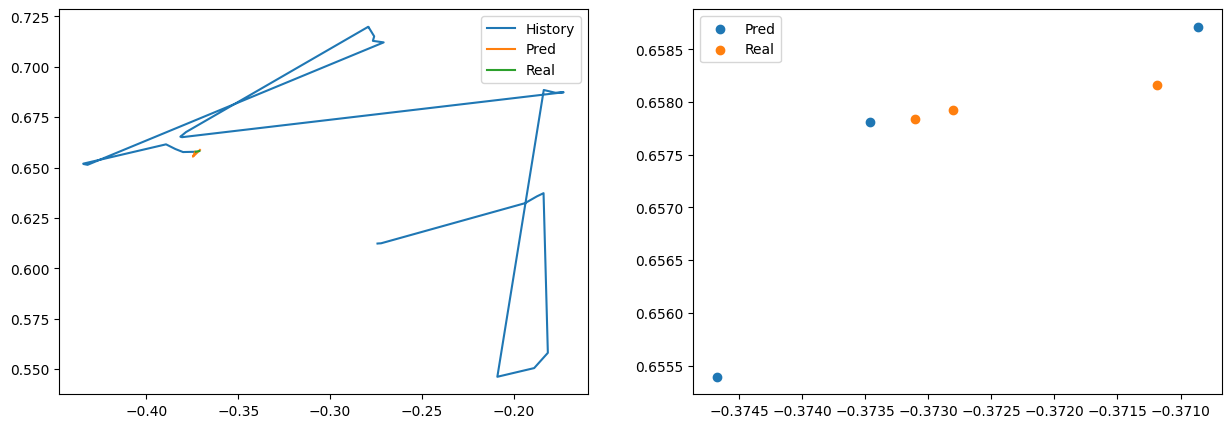

In [23]:
data, real, pred = pred_batch(model, validation_loader, minor_i)
plot_prediction(data, real, pred)